<a href="https://colab.research.google.com/github/Syauqi366/praktikum-machine-learning-/blob/main/Praktikum4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount ('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
path = "/content/gdrive/MyDrive/Praktikum_ml/Praktikum4ML"

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, classification_report, RocCurveDisplay, ConfusionMatrixDisplay
)


In [ ]:
df = pd.read_csv(path+f"/data/stunting_wasting_dataset.csv")
df.head()

,Jenis Kelamin,Umur (bulan),Tinggi Badan (cm),Berat Badan (kg),Stunting,Wasting
0,Laki-laki,19,91.6,13.3,Tall,Risk of Overweight
1,Laki-laki,20,77.7,8.5,Stunted,Underweight
2,Laki-laki,10,79.0,10.3,Normal,Risk of Overweight
3,Perempuan,2,50.3,8.3,Severely Stunted,Risk of Overweight
4,Perempuan,5,56.4,10.9,Severely Stunted,Risk of Overweight


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Jenis Kelamin      100000 non-null  object 
 1   Umur (bulan)       100000 non-null  int64  
 2   Tinggi Badan (cm)  100000 non-null  float64
 3   Berat Badan (kg)   100000 non-null  float64
 4   Stunting           100000 non-null  object 
 5   Wasting            100000 non-null  object 
dtypes: float64(2), int64(1), object(3)
memory usage: 4.6+ MB


In [ ]:
#cek misking value
df.isnull().sum()

,0
Jenis Kelamin,0
Umur (bulan),0
Tinggi Badan (cm),0
Berat Badan (kg),0
Stunting,0
Wasting,0


In [ ]:
# Cek nilai unik pada kolom 'Stunting'
df['Stunting'].unique()

# Output:
# array(['Tall', 'Stunted', 'Normal', 'Severely Stunted'], dtype=object)

# Cek nilai unik pada kolom 'Jenis Kelamin'
df['Jenis Kelamin'].unique()

# Output:
# array(['Laki-laki', 'Perempuan'], dtype=object)


array(['Laki-laki', 'Perempuan'], dtype=object)

In [ ]:
# 1. Mapping kolom Stunting -> biner
map_stunt = {'Stunted': 1, 'Severely Stunted': 1, 'Normal': 0, 'Tall': 0}
df['Stunting_bin'] = df['Stunting'].map(map_stunt).astype('Int64')

# 2. Mapping kolom Jenis Kelamin -> biner
# Laki-laki = 1, Perempuan = 0
df['JK_bin'] = (df['Jenis Kelamin'] == 'Laki-laki').astype(int)

print("Distribusi Stunting_bin:\n", df['Stunting_bin'].value_counts())
print("\nDistribusi JK_bin:\n", df['JK_bin'].value_counts())


Distribusi Stunting_bin:
 Stunting_bin
0    78021
1    21979
Name: count, dtype: Int64

Distribusi JK_bin:
 JK_bin
1    50179
0    49821
Name: count, dtype: int64


In [ ]:
corr_matrix = df.corr(numeric_only=True)
corr_matrix

,Umur (bulan),Tinggi Badan (cm),Berat Badan (kg),Stunting_bin,JK_bin
Umur (bulan),1.000000,0.875869,0.665389,0.038630,0.004046
Tinggi Badan (cm),0.875869,1.000000,0.626005,-0.283855,0.073505
Berat Badan (kg),0.665389,0.626005,1.000000,0.021090,0.045797
Stunting_bin,0.038630,-0.283855,0.021090,1.000000,-0.005981
JK_bin,0.004046,0.073505,0.045797,-0.005981,1.000000


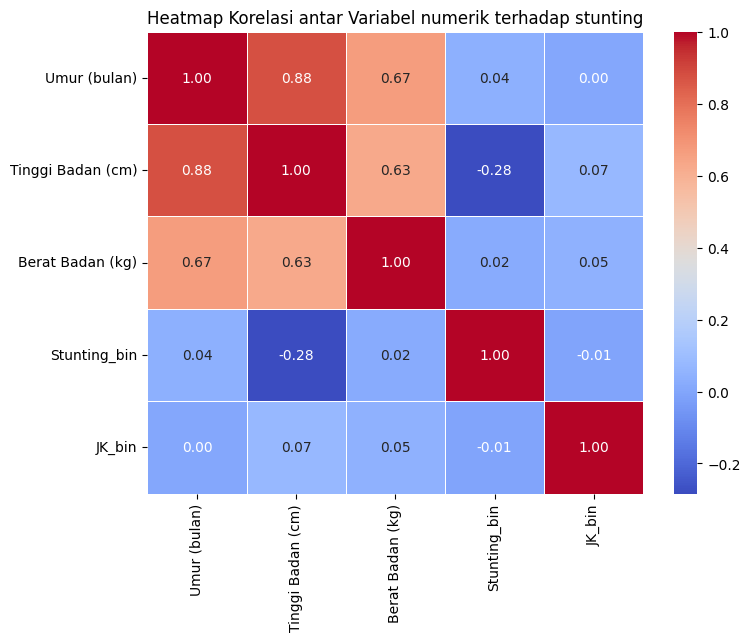

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Heatmap Korelasi antar Variabel numerik terhadap stunting', fontsize=12)
plt.show()

In [ ]:
# Fitur numerik dan gender
feature_num = ['Umur (bulan)', 'Tinggi Badan (cm)', 'Berat Badan (kg)']
feature_bin = ['JK_bin']

# Gabungkan & drop missing values
use_cols = feature_num + feature_bin + ['Stunting_bin']
df_model = df[use_cols].dropna().copy()

X = df_model[feature_num + feature_bin]
y = df_model['Stunting_bin']

print("X shape:", X.shape)
print("y shape:", y.shape)


X shape: (100000, 4)
y shape: (100000,)


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Data latih:", X_train.shape)
print("Data uji:", X_test.shape)


Data latih: (80000, 4)
Data uji: (20000, 4)


In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

# Scale hanya fitur numerik, gender langsung passthrough
preprocess = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), feature_num),
        ('bin', 'passthrough', feature_bin)
    ],
    remainder='drop'
)

model = LogisticRegression(
    max_iter=1000,
    solver='lbfgs',
    class_weight='balanced',
    random_state=42
)

clf = Pipeline([
    ('preprocess', preprocess),
    ('model', model)
])

# Latih model
clf.fit(X_train, y_train)
print("✅ Model Logistic Regression berhasil dilatih.")


✅ Model Logistic Regression berhasil dilatih.


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Prediksi & probabilitas
y_pred = clf.predict(X_test)
y_prob = clf.predict_proba(X_test)[:, 1]

# Hitung metrik evaluasi
print(f"Akurasi   : {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision : {precision_score(y_test, y_pred, zero_division=0):.4f}")
print(f"Recall    : {recall_score(y_test, y_pred, zero_division=0):.4f}")
print(f"F1-Score  : {f1_score(y_test, y_pred, zero_division=0):.4f}")
print(f"ROC-AUC   : {roc_auc_score(y_test, y_prob):.4f}")



Akurasi   : 0.9055
Precision : 0.7152
Recall    : 0.9472
F1-Score  : 0.8150
ROC-AUC   : 0.9656


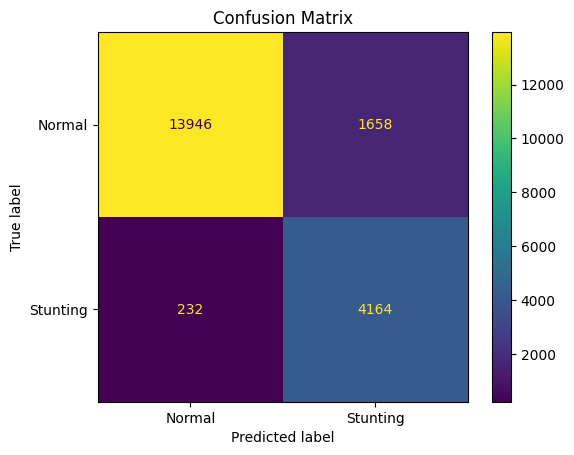

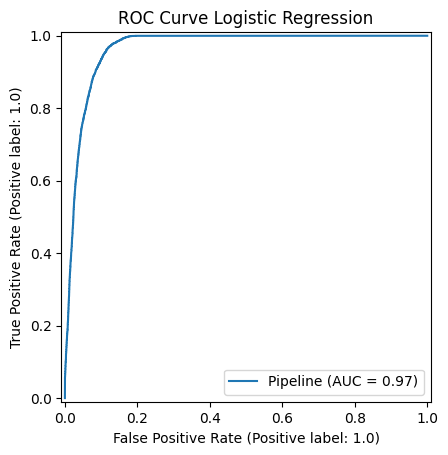

In [ ]:

# Confusion Matrix
ConfusionMatrixDisplay(
    confusion_matrix(y_test, y_pred),
    display_labels=['Normal', 'Stunting']
).plot(values_format='d')
plt.title("Confusion Matrix")
plt.show()

# ROC Curve
RocCurveDisplay.from_estimator(clf, X_test, y_test)
plt.title("ROC Curve Logistic Regression")
plt.show()


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred, target_names=['Tidak Stunting (0)', 'Stunting(1)']))

                    precision    recall  f1-score   support

Tidak Stunting (0)       0.98      0.89      0.94     15604
       Stunting(1)       0.72      0.95      0.82      4396

          accuracy                           0.91     20000
         macro avg       0.85      0.92      0.88     20000
      weighted avg       0.92      0.91      0.91     20000



In [ ]:
from sklearn.model_selection import cross_val_score
import numpy as np

# Lakukan cross validation (cv=5 berarti 5-fold)
scores = cross_val_score(clf, X, y, cv=5)

# Tampilkan hasil
print("Skor tiap fold:", scores)
print("Rata-rata akurasi:", np.mean(scores))
print("Standar deviasi:", np.std(scores))


Skor tiap fold: [0.9062  0.9013  0.9052  0.89905 0.9002 ]
Rata-rata akurasi: 0.9023899999999999
Standar deviasi: 0.0028125433329995106


In [ ]:
# Ambil nama fitur & koefisien
feat_names = feature_num + feature_bin
coefs = clf.named_steps['model'].coef_[0]
odds = np.exp(coefs)

coef_df = pd.DataFrame({
    'Fitur': feat_names,
    'Koefesien (log-odds)': coefs,
    'Odds Ratio (e^coef)': odds
}).sort_values('Odds Ratio (e^coef)', ascending=False)

display(coef_df)

,Fitur,Koefesien (log-odds),Odds Ratio (e^coef)
0,Umur (bulan),8.525912,5043.782458
3,JK_bin,1.675944,5.343839
2,Berat Badan (kg),0.661090,1.936903
1,Tinggi Badan (cm),-10.535980,0.000027


In [ ]:
# Contoh 2 anak
data_baru = pd.DataFrame({
    'Umur (bulan)': [24, 10],
    'Tinggi Badan (cm)': [79.0, 72.5],
    'Berat Badan (kg)': [9.2, 7.8],
    'JK_bin': [1, 0]  # 1 = Laki-laki, 0 = Perempuan
})

pred = clf.predict(data_baru)
prob = clf.predict_proba(data_baru)[:, 1]

hasil = data_baru.copy()
hasil['Prob_Stunting'] = prob
hasil['Pred (0=Tidak,1=Ya)'] = pred
display(hasil)


,Umur (bulan),Tinggi Badan (cm),Berat Badan (kg),JK_bin,Prob_Stunting,"Pred (0=Tidak,1=Ya)"
0,24,79.0,9.2,1,0.998208,1.0
1,10,72.5,7.8,0,0.002094,0.0
